# Setup

In [ ]:
!nvidia-smi

Sun Nov 22 03:25:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Import important libraries, set constants

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

histories = {}

In [ ]:
# Time callback for keeping track of and comparing model train times

import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
import os

if not os.path.exists('/content/models'):
    os.mkdir('/content/models')

# Callback to stop training if validation accuracy does not improve after 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5)
# Callback to save model after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/models/{epoch:02d}',
                                                monitor='val_acc',
                                                mode="max")
# Log model statistics
log = tf.keras.callbacks.CSVLogger('/content/models/log.csv')
time_callback = TimeHistory()

In [ ]:
#get all required files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()

def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

link='https://drive.google.com/drive/folders/1mj-LAHcnvUiWcsM5y0HZKCVCW6cpgHU0'

folder_id="1mj-LAHcnvUiWcsM5y0HZKCVCW6cpgHU0"

folder_download(folder_id)

Permission denied: https://drive.google.com/uc?id=1WeRyfUhc1oXUBzqKH-6WOb1Nm0HTlzz1
Maybe you need to change permission over 'Anyone with the link'?




---

### Load CelebA Dataset

In [ ]:
!unzip "/content/img_align_celeba.zip"

In [ ]:
# Set classes, train test split for CelebA dataset

from sklearn.model_selection import train_test_split

df = pd.read_csv('list_attr_celeba.txt', header=0, delim_whitespace=True)

df.loc[df['Male'] == 1, 'Male'] = 'm'
df.loc[df['Male'] == -1, 'Male'] = 'f'

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
# Create generators for train and test sets, perform data augmentation for train set

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen_ca = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/img_align_celeba/',
                                                     x_col='image_id',
                                                     y_col='Male',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen_ca = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 162079 validated image filenames belonging to 2 classes.
Found 40520 validated image filenames belonging to 2 classes.




---

### Load Adience Dataset

In [ ]:
!unzip "/content/aligned.zip"

In [ ]:
# Concat the different attribute files for Adience dataset

df = pd.DataFrame()
for i in range(0,5):
    df = pd.concat([df, pd.read_csv(f'fold_{i}_data.txt', sep='\t')])

In [ ]:
from sklearn.model_selection import train_test_split

# Clean dataset by removing NAs
df = df[df['gender'].notna()]
df = df[df['age'] != 'None']
df = df[df['gender'] != 'u']

# Cleanup age categories
df.loc[df['age'] == '(27, 32)', 'age'] = '(25, 32)'
df.loc[df['age'] == '(38, 42)', 'age'] = '(38, 43)'
df.loc[df['age'] == '29', 'age'] = '(25, 32)'
df.loc[df['age'] == '2', 'age'] = '(0, 2)'
df.loc[df['age'] == '42', 'age'] = '(38, 43)'
df['age'].value_counts()
df = df[df.age.isin(['(0, 2)',
                     '(4, 6)',
                     '(8, 12)',
                     '(15, 20)',
                     '(25, 32)',
                     '(38, 43)',
                     '(48, 53)',
                     '(60, 100)'])]

# Generate image filepaths
df['filepath'] = df.apply(lambda row: row['user_id'] +
                          '/landmark_aligned_face.' + str(row['face_id']) + '.' +
                          row['original_image'],
         axis = 1
)
df = df.loc[:, ['filepath', 'age', 'gender']]

# Train test split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
# Create generators for train and test sets

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.




---

## Benchmark

ImageNet weights, No data augmentation



In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)
histories['benchmark'] = (history, time_callback.times)

Epoch 1/20
410/410 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8511WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
410/410 [==============================] - 267s 652ms/step - loss: 0.3247 - accuracy: 0.8511 - val_loss: 0.2001 - val_accuracy: 0.9206
Epoch 2/20
410/410 [==============================] - 256s 624ms/step - loss: 0.1222 - accuracy: 0.9538 - val_loss: 0.2331 - val_accuracy: 0.9065
Epoch 3/20
410/410 [==============================] - 258s 628ms/step - loss: 0.0438 - accu

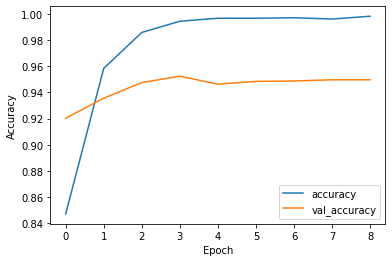

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

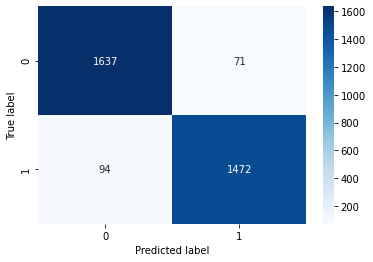

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



---

# 1. Modify architecture, various techniques

## ImageNet weights, Data augmentation

In [ ]:
# Generate train dataset with data augmentation

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_gen,
                    epochs=25,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/25
410/410 [==============================] - 522s 1s/step - loss: 0.3523 - accuracy: 0.8384 - val_loss: 0.2434 - val_accuracy: 0.8998
Epoch 2/25
410/410 [==============================] - 517s 1s/step - loss: 0.1779 - accuracy: 0.9280 - val_loss: 0.1511 - val_accuracy: 0.9420
Epoch 3/25
410/410 [==============================] - 534s 1s/step - loss: 0.1323 - accuracy: 0.9500 - val_loss: 0.1279 - val_accuracy: 0.9557
Epoch 4/25
410/410 [==============================] - 531s 1s/step - loss: 0.0962 - accuracy: 0.9650 - val_loss: 0.1286 - val_accuracy: 0.9527
Epoch 5/25
410/410 [==============================] - 521s 1s/step - loss: 0.0793 - accuracy: 0.9705 - val_loss: 0.1273 - val_accuracy: 0.9530
Epoch 6/25
410/410 [==============================] - 515s 1s/step - loss: 0.0604 - accuracy: 0.9802 - val_loss: 0.1354 - val_accuracy: 0.9578
Epoch 7/25
410/410 [==============================] - 513s 1s/step - loss: 0.0545 - accuracy: 0.9812 - val_loss: 0.1106 - val_accuracy: 0.9627

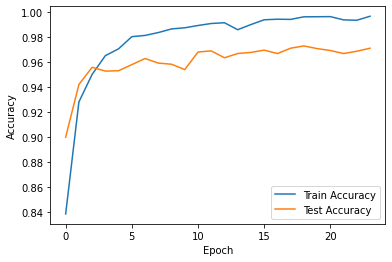

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

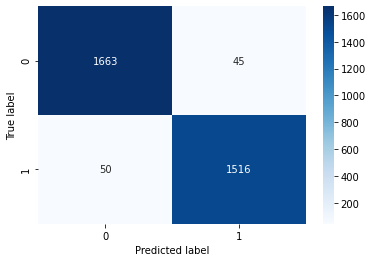

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

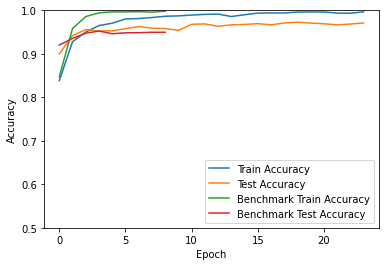

In [ ]:
# Compare with baseline
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(histories['benchmark'][0].history['accuracy'], label='Benchmark Train Accuracy')
plt.plot(histories['benchmark'][0].history['val_accuracy'], label='Benchmark Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# Compare time taken to train with and without data augmentation

pd.DataFrame([[sum(histories['benchmark'][1][1:]) / len(histories['benchmark'][1][1:]), sum(histories['benchmark'][1])],
              [sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Benchmark', 'Current'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Benchmark,274.502737,2481.344435
Current,515.069000,12374.432937


## No Pretrained Weights

In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights=None,
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_gen,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/100
410/410 [==============================] - 537s 1s/step - loss: 0.7145 - accuracy: 0.5606 - val_loss: 0.6911 - val_accuracy: 0.6072
Epoch 2/100
410/410 [==============================] - 526s 1s/step - loss: 0.6746 - accuracy: 0.6130 - val_loss: 0.6694 - val_accuracy: 0.5947
Epoch 3/100
410/410 [==============================] - 511s 1s/step - loss: 0.6293 - accuracy: 0.6556 - val_loss: 0.6604 - val_accuracy: 0.6335
Epoch 4/100
410/410 [==============================] - 502s 1s/step - loss: 0.6062 - accuracy: 0.6768 - val_loss: 0.6031 - val_accuracy: 0.6784
Epoch 5/100
410/410 [==============================] - 534s 1s/step - loss: 0.5785 - accuracy: 0.6977 - val_loss: 0.7653 - val_accuracy: 0.5889
Epoch 6/100
410/410 [==============================] - 528s 1s/step - loss: 0.5582 - accuracy: 0.7114 - val_loss: 0.7675 - val_accuracy: 0.6255
Epoch 7/100
410/410 [==============================] - 528s 1s/step - loss: 0.5284 - accuracy: 0.7332 - val_loss: 0.4975 - val_accuracy:

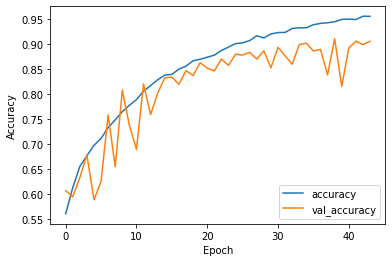

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

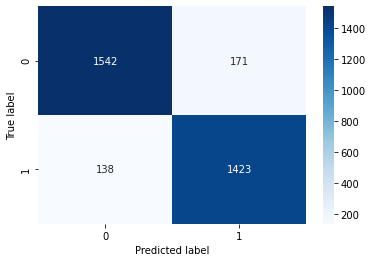

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['No Pretrained Weights'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
No Pretrained Weights,498.677362,21987.943659


## Deeper Fully-Connected Layers

In [ ]:
# Generate train dataset without data augmentation

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights
# Add additional dense layer to fully connected segment to test

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(train_data_gen,
                    epochs=30,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/30
410/410 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8464WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
410/410 [==============================] - 253s 617ms/step - loss: 0.3332 - accuracy: 0.8464 - val_loss: 0.1880 - val_accuracy: 0.9236
Epoch 2/30
410/410 [==============================] - 247s 601ms/step - loss: 0.1256 - accuracy: 0.9527 - val_loss: 0.1623 - val_accuracy: 0.9380
Epoch 3/30
410/410 [==============================] - 245s 596ms/step - loss: 0.0452 - accu

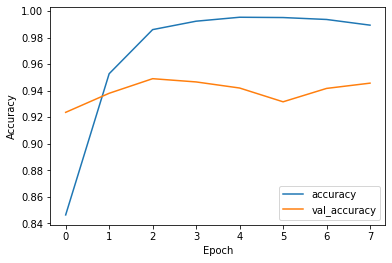

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

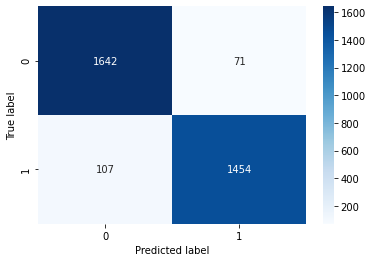

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb
 
model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()
 
predict = np.argmax(predict, axis=1)
 
cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Time taken to train model

pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Deep'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Deep,245.265501,1982.109493


## VGG16 vs TensorflowV3
InceptionV3 is a deep CNN, with depth of 159, while VGG16 only has a depth of 23

In [ ]:
# Initialise VGG16 model, with pretrained ImageNet weights

base_model = tf.keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                         pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)
histories['benchmark'] = (history, time_callback.times)

Epoch 1/20
410/410 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.6802WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
410/410 [==============================] - 372s 907ms/step - loss: 0.5812 - accuracy: 0.6802 - val_loss: 0.5350 - val_accuracy: 0.6955
Epoch 2/20
410/410 [==============================] - 371s 904ms/step - loss: 0.4402 - accuracy: 0.7881 - val_loss: 0.3661 - val_accuracy: 0.8280
Epoch 3/20
410/410 [==============================] - 373s 910ms/step - loss: 0.3737 - accu

In [ ]:
# Load best model
model = tf.keras.models.load_model('/content/models/05')

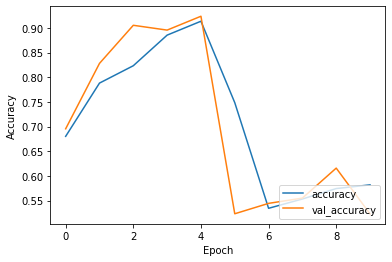

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

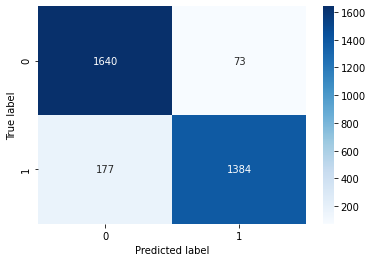

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['No Pretrained Weights'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
No Pretrained Weights,368.650897,3702.636299




---

# 2. Age and Gender simultaneously 

## Without Data Augmentation

In [ ]:
# Create generators for train and test sets for age

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='age',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='age',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 8 classes.
Found 3274 validated image filenames belonging to 8 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

age_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(age_model)
model.add(tf.keras.layers.Dense(8))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 288s 702ms/step - loss: 1.2114 - accuracy: 0.5386 - val_loss: 0.8862 - val_accuracy: 0.6530
Epoch 2/20
410/410 [==============================] - 286s 698ms/step - loss: 0.6339 - accuracy: 0.7702 - val_loss: 0.8211 - val_accuracy: 0.6979
Epoch 3/20
410/410 [==============================] - 290s 708ms/step - loss: 0.3312 - accuracy: 0.8902 - val_loss: 0.7033 - val_accuracy: 0.7474
Epoch 4/20
410/410 [==============================] - 290s 707ms/step - loss: 0.1779 - accuracy: 0.9461 - val_loss: 0.8253 - val_accuracy: 0.7321
Epoch 5/20
410/410 [==============================] - 287s 701ms/step - loss: 0.0875 - accuracy: 0.9766 - val_loss: 0.6990 - val_accuracy: 0.7813
Epoch 6/20
410/410 [==============================] - 288s 703ms/step - loss: 0.0571 - accuracy: 0.9854 - val_loss: 0.7332 - val_accuracy: 0.7841
Epoch 7/20
410/410 [==============================] - 287s 701ms/step - loss: 0.0382 - accuracy: 0.9903 - val_loss: 0.7411 -

In [ ]:
# Create generators for train and test sets for gender

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

gender_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(gender_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 278s 678ms/step - loss: 0.3268 - accuracy: 0.8495 - val_loss: 0.2091 - val_accuracy: 0.9142
Epoch 2/20
410/410 [==============================] - 274s 667ms/step - loss: 0.1158 - accuracy: 0.9607 - val_loss: 0.1880 - val_accuracy: 0.9246
Epoch 3/20
410/410 [==============================] - 275s 671ms/step - loss: 0.0447 - accuracy: 0.9874 - val_loss: 0.1534 - val_accuracy: 0.9496
Epoch 4/20
410/410 [==============================] - 275s 671ms/step - loss: 0.0227 - accuracy: 0.9944 - val_loss: 0.1641 - val_accuracy: 0.9481
Epoch 5/20
410/410 [==============================] - 277s 675ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.1897 - val_accuracy: 0.9407
Epoch 6/20
410/410 [==============================] - 272s 663ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.2003 - val_accuracy: 0.9420
Epoch 7/20
410/410 [==============================] - 272s 665ms/step - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.1727 -

In [ ]:
# Simultaneously find age and gender features, then predict gender from both features
age_model._name = 'inception_v3_age'
gender_model._name = 'inception_v3_gender'

age_model.trainable = False
gender_model.trainable = False

input = tf.keras.Input(shape=(299, 299, 3))
age_model = age_model(input)
gender_model = gender_model(input)
age_model = tf.keras.Model(inputs=input, outputs=age_model)
gender_model = tf.keras.Model(inputs=input, outputs=gender_model)
model = tf.keras.layers.concatenate([age_model.output, gender_model.output])
model = tf.keras.layers.Dense(2)(model)
model = tf.keras.Model(inputs=input, outputs=model)

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3_age (Functional)   (None, 2048)         21802784    input_6[0][0]                    
__________________________________________________________________________________________________
inception_v3_gender (Functional (None, 2048)         21802784    input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 4096)         0           inception_v3_age[1][0]           
                                                                 inception_v3_gender[1

In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 300s 732ms/step - loss: 0.0353 - accuracy: 0.9966 - val_loss: 0.1384 - val_accuracy: 0.9505
Epoch 2/20
410/410 [==============================] - 290s 708ms/step - loss: 0.0073 - accuracy: 0.9998 - val_loss: 0.1432 - val_accuracy: 0.9499
Epoch 3/20
410/410 [==============================] - 288s 704ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.1451 - val_accuracy: 0.9524
Epoch 4/20
410/410 [==============================] - 293s 714ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.1490 - val_accuracy: 0.9520
Epoch 5/20
410/410 [==============================] - 294s 718ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.1518 - val_accuracy: 0.9517
Epoch 6/20
410/410 [==============================] - 296s 722ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.1538 - val_accuracy: 0.9517
Epoch 7/20
410/410 [==============================] - 295s 719ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.1567 -

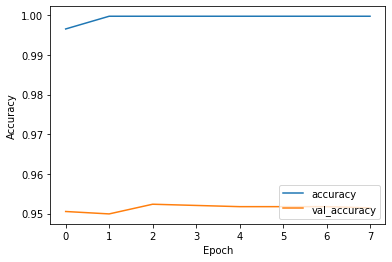

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## With Data Augmentation

In [ ]:
# Create generators for train and test sets for age

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='age',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='age',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 8 classes.
Found 3274 validated image filenames belonging to 8 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

age_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(age_model)
model.add(tf.keras.layers.Dense(8))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 536s 1s/step - loss: 1.2656 - accuracy: 0.5170 - val_loss: 0.9302 - val_accuracy: 0.6368
Epoch 2/20
410/410 [==============================] - 540s 1s/step - loss: 0.8279 - accuracy: 0.6831 - val_loss: 0.8829 - val_accuracy: 0.6671
Epoch 3/20
410/410 [==============================] - 542s 1s/step - loss: 0.6215 - accuracy: 0.7691 - val_loss: 0.8156 - val_accuracy: 0.6924
Epoch 4/20
410/410 [==============================] - 545s 1s/step - loss: 0.4882 - accuracy: 0.8229 - val_loss: 0.5991 - val_accuracy: 0.7831
Epoch 5/20
410/410 [==============================] - 535s 1s/step - loss: 0.3784 - accuracy: 0.8672 - val_loss: 0.6228 - val_accuracy: 0.7828
Epoch 6/20
410/410 [==============================] - 527s 1s/step - loss: 0.3127 - accuracy: 0.8858 - val_loss: 0.5606 - val_accuracy: 0.8051
Epoch 7/20
410/410 [==============================] - 527s 1s/step - loss: 0.2450 - accuracy: 0.9140 - val_loss: 0.6078 - val_accuracy: 0.7999

In [ ]:
# Create generators for train and test sets for gender

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.


In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

gender_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(gender_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 540s 1s/step - loss: 0.3475 - accuracy: 0.8381 - val_loss: 0.2878 - val_accuracy: 0.8772
Epoch 2/20
410/410 [==============================] - 550s 1s/step - loss: 0.1937 - accuracy: 0.9237 - val_loss: 0.1707 - val_accuracy: 0.9352
Epoch 3/20
410/410 [==============================] - 551s 1s/step - loss: 0.1315 - accuracy: 0.9491 - val_loss: 0.1412 - val_accuracy: 0.9429
Epoch 4/20
410/410 [==============================] - 536s 1s/step - loss: 0.1061 - accuracy: 0.9610 - val_loss: 0.1288 - val_accuracy: 0.9548
Epoch 5/20
410/410 [==============================] - 515s 1s/step - loss: 0.0783 - accuracy: 0.9710 - val_loss: 0.1571 - val_accuracy: 0.9505
Epoch 6/20
410/410 [==============================] - 535s 1s/step - loss: 0.0632 - accuracy: 0.9778 - val_loss: 0.1435 - val_accuracy: 0.9551
Epoch 7/20
410/410 [==============================] - 529s 1s/step - loss: 0.0520 - accuracy: 0.9824 - val_loss: 0.1500 - val_accuracy: 0.9533

In [ ]:
# Simultaneously find age and gender features, then predict gender from both features
age_model._name = 'inception_v3_age'
gender_model._name = 'inception_v3_gender'

age_model.trainable = False
gender_model.trainable = False

input = tf.keras.Input(shape=(299, 299, 3))
age_model = age_model(input)
gender_model = gender_model(input)
age_model = tf.keras.Model(inputs=input, outputs=age_model)
gender_model = tf.keras.Model(inputs=input, outputs=gender_model)
model = tf.keras.layers.concatenate([age_model.output, gender_model.output])
model = tf.keras.layers.Dense(2)(model)
model = tf.keras.Model(inputs=input, outputs=model)

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3_age (Functional)   (None, 2048)         21802784    input_4[0][0]                    
__________________________________________________________________________________________________
inception_v3_gender (Functional (None, 2048)         21802784    input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 4096)         0           inception_v3_age[1][0]           
                                                                 inception_v3_gender[1]

In [29]:
# Fit model to train data

history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/20
410/410 [==============================] - 517s 1s/step - loss: 0.0516 - accuracy: 0.9919 - val_loss: 0.1083 - val_accuracy: 0.9618
Epoch 2/20
410/410 [==============================] - 512s 1s/step - loss: 0.0194 - accuracy: 0.9971 - val_loss: 0.1111 - val_accuracy: 0.9615
Epoch 3/20
410/410 [==============================] - 515s 1s/step - loss: 0.0153 - accuracy: 0.9974 - val_loss: 0.1140 - val_accuracy: 0.9618
Epoch 4/20
410/410 [==============================] - 520s 1s/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.1167 - val_accuracy: 0.9633
Epoch 5/20
410/410 [==============================] - 525s 1s/step - loss: 0.0117 - accuracy: 0.9972 - val_loss: 0.1187 - val_accuracy: 0.9633
Epoch 6/20
410/410 [==============================] - 533s 1s/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.1213 - val_accuracy: 0.9630
Epoch 7/20
410/410 [==============================] - 521s 1s/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.1229 - val_accuracy: 0.9640

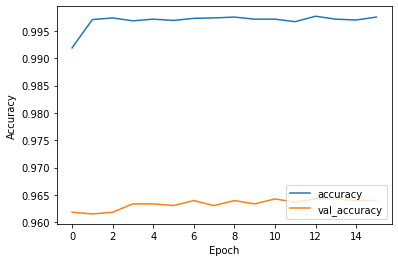

In [30]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# 3. Pretraining on CelebA

In [ ]:
# Initialise InceptionV3 model, with pretrained ImageNet weights

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Pretrain model on CelebA dataset

history = model.fit(train_data_gen_ca,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen_ca,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 8/100
5065/5065 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9929WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/08/assets
5065/5065 [==============================] - 4776s 943ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 0.0154 - val_accuracy: 0.9948
Epoch 9/100
5065/5065 [==============================] - 4540s 896ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 0.0176 - val_accuracy: 0.9939
Epoch 10/100
5065/5065 [==============================] - 4655s 919ms/step - loss

In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=1)

print(f"Test accuracy: {test_acc}")

103/103 [==============================] - 47s 459ms/step - loss: 0.5311 - accuracy: 0.8207
Test accuracy: 0.8207086324691772


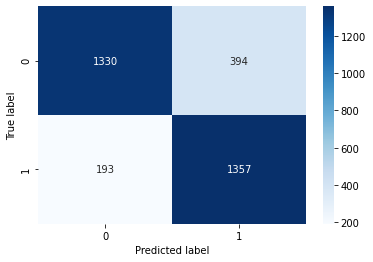

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb
 
model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()
 
predict = np.argmax(predict, axis=1)
 
cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Save model for future experimentation
model.save('/content/models/celeba')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CZ4042/models/celeba/assets


In [ ]:
# Don't train feature selection weights
model.layers[0].trainable = False

# Train on Adience dataset
history = model.fit(train_data_gen,
                    epochs=30,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/30
410/410 [==============================] - 296s 722ms/step - loss: 0.2059 - accuracy: 0.9212 - val_loss: 0.1152 - val_accuracy: 0.9566
Epoch 2/30
410/410 [==============================] - 283s 691ms/step - loss: 0.0681 - accuracy: 0.9760 - val_loss: 0.0898 - val_accuracy: 0.9673
Epoch 3/30
410/410 [==============================] - 287s 699ms/step - loss: 0.0278 - accuracy: 0.9918 - val_loss: 0.1086 - val_accuracy: 0.9661
Epoch 4/30
410/410 [==============================] - 284s 693ms/step - loss: 0.0134 - accuracy: 0.9967 - val_loss: 0.0949 - val_accuracy: 0.9698
Epoch 5/30
410/410 [==============================] - 287s 700ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.1065 - val_accuracy: 0.9688
Epoch 6/30
410/410 [==============================] - 286s 698ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.1002 - val_accuracy: 0.9692
Epoch 7/30
410/410 [==============================] - 286s 697ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.1048 -

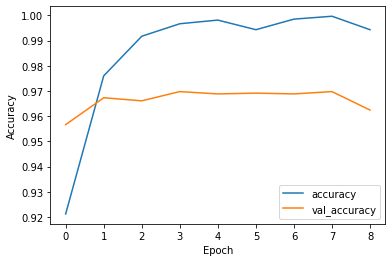

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

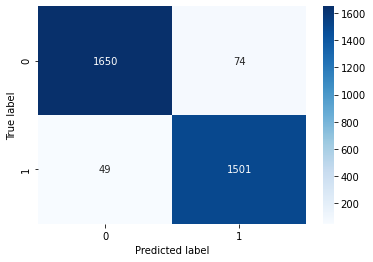

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb
 
model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()
 
predict = np.argmax(predict, axis=1)
 
cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Time taken to train model

pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Deep'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Deep,286.517004,2593.732514


In [ ]:
# Load model pretrained on celeba
model = tf.keras.models.load_model('/content/models/celeba')

In [ ]:
# Don't train feature selection weights
model.layers[0].trainable = False

# Train model, allowing feature selection weights to be trainable
history = model.fit(train_data_gen,
                    epochs=30,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/30
410/410 [==============================] - 284s 692ms/step - loss: 0.1986 - accuracy: 0.9258 - val_loss: 0.1091 - val_accuracy: 0.9618
Epoch 2/30
410/410 [==============================] - 285s 695ms/step - loss: 0.0603 - accuracy: 0.9806 - val_loss: 0.0971 - val_accuracy: 0.9646
Epoch 3/30
410/410 [==============================] - 288s 702ms/step - loss: 0.0374 - accuracy: 0.9892 - val_loss: 0.0950 - val_accuracy: 0.9676
Epoch 4/30
410/410 [==============================] - 287s 700ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.1006 - val_accuracy: 0.9704
Epoch 5/30
410/410 [==============================] - 289s 704ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.3829 - val_accuracy: 0.8995
Epoch 6/30
410/410 [==============================] - 292s 712ms/step - loss: 0.0364 - accuracy: 0.9873 - val_loss: 0.1041 - val_accuracy: 0.9658
Epoch 7/30
410/410 [==============================] - 295s 718ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0991 -

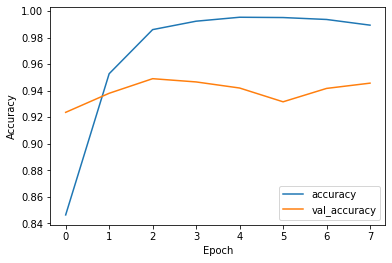

In [ ]:
# Plot train and test accuracies per epoch

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

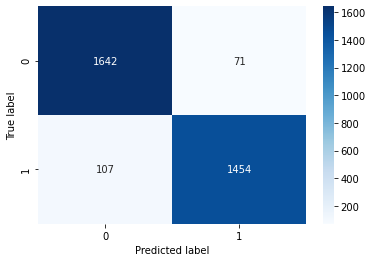

In [ ]:
# Plot confusion matrix for model

from sklearn.metrics import confusion_matrix
import seaborn as sb
 
model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()
 
predict = np.argmax(predict, axis=1)
 
cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Time taken to train model

pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Deep'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Deep,245.265501,1982.109493
